## Comparing COVID Crash Data: Louisville vs. Cincinnati

##### *JD D'Annunzio*



##### First, let's import the libraries we'll need.

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob
import os

##### Next, let's use `pandas` to read in data from our local CSV containing Cincinnati's crash data. We don't need every column here - it's a 36MB file - so we'll filter it down to only the columns we want. Then, we'll display the top 5 rows and headers to ensure we got the data we expected.

In [166]:
cinTest = pd.read_csv('assets/Cincy Crash Data.csv')
cinMain = cinTest.filter(["AGE", "CRASHDATE", "INJURIES", "TYPEOFPERSON"], axis=1)
cinMain.head()

/var/folders/6f/pzb1mp0j39b1gqfhfdyf0qr80000gn/T/ipykernel_1873/67805717.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  cinTest = pd.read_csv('assets/Cincy Crash Data.csv')


,AGE,CRASHDATE,INJURIES,TYPEOFPERSON
0,NaN,7/10/22 0:02,NaN,NaN
1,NaN,7/9/22 22:21,NaN,NaN
2,37.0,7/9/22 21:18,5 - NO APPARENTY INJURY,D - DRIVER
3,29.0,7/9/22 21:18,5 - NO APPARENTY INJURY,P - PEDESTRIAN
4,34.0,7/9/22 21:09,5 - NO APPARENTY INJURY,D - DRIVER


##### For the sake of caution, we'll also check to make sure the data types `pandas` assigned are correct, or at least workable for our needs.

In [167]:
cinMain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95178 entries, 0 to 95177
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AGE           81629 non-null  float64
 1   CRASHDATE     95178 non-null  object 
 2   INJURIES      95085 non-null  object 
 3   TYPEOFPERSON  95090 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.9+ MB


##### `float64` is a silly dtype for an Age column, but Age isn't always known, so this produces an error for blank entries. That isn't relevant to our project, so we can ignore it.

##### For analysis and plotting reasons, we'll need to standardize the `CRASHDATE` column in a format `pandas` can understand. We'll check the top 5 rows again to ensure the conversion worked as expected.

In [168]:
cinMain["CRASHDATE"] = pd.to_datetime(cinMain["CRASHDATE"]).dt.date
cinMain.head()

,AGE,CRASHDATE,INJURIES,TYPEOFPERSON
0,NaN,2022-07-10,NaN,NaN
1,NaN,2022-07-09,NaN,NaN
2,37.0,2022-07-09,5 - NO APPARENTY INJURY,D - DRIVER
3,29.0,2022-07-09,5 - NO APPARENTY INJURY,P - PEDESTRIAN
4,34.0,2022-07-09,5 - NO APPARENTY INJURY,D - DRIVER


##### Now comes the fun part. The CSV was formatted to provide details on each individual crash, but we want to plot the total occurrences *per day*. It would take me a long time to count 95,178 rows. Luckily, `pandas` is a little faster.

##### Again, we'll check the top 5 rows of our new series, `cinCrashes`, to make sure we get the result we expected.

In [169]:
cinCrashes = cinMain.groupby(["CRASHDATE"]).size()
cinCrashes.head()

CRASHDATE
2019-07-09     90
2019-07-10    112
2019-07-11    100
2019-07-12     91
2019-07-13    105
dtype: int64

##### Now that we have the data we wanted, let's try a simple bar plot.

<AxesSubplot:xlabel='CRASHDATE'>

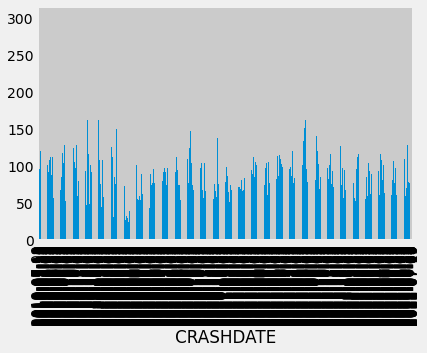

In [170]:
cinCrashes.plot(kind='bar')

##### That's... pretty hideous. It gives us a rough idea of crashes per day, but the x-axis is a mess. Let's try a little finesse.

(0.0, 310.0)

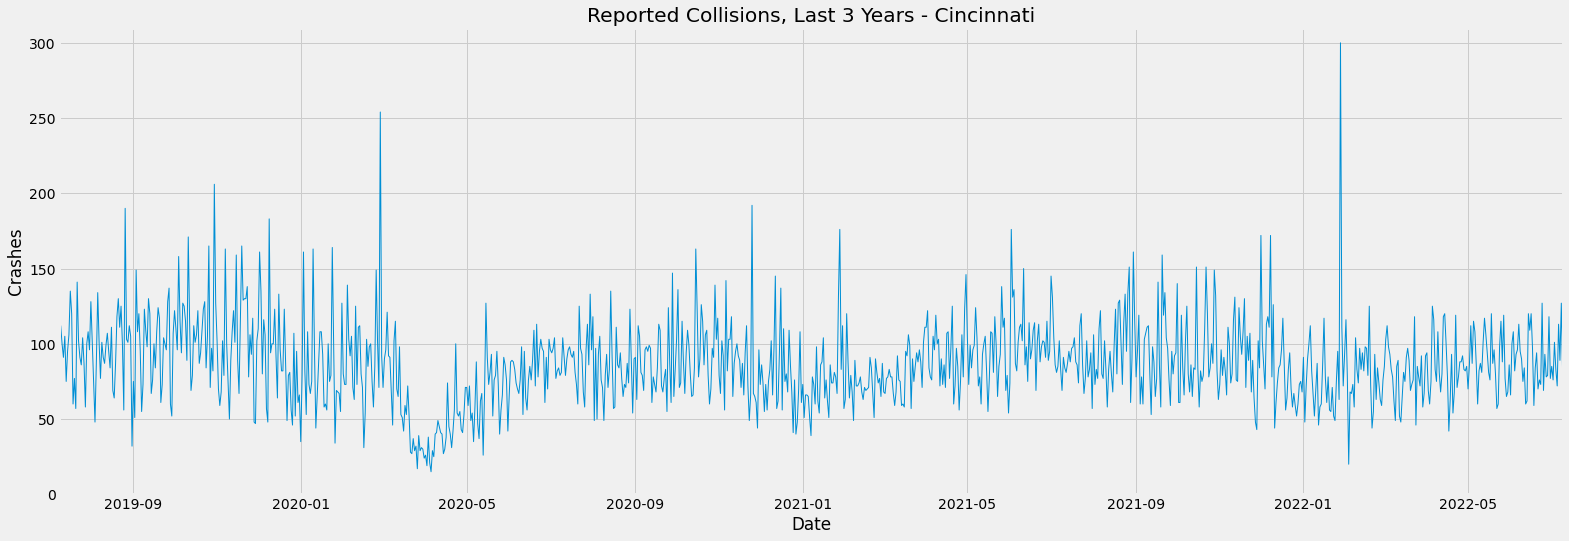

In [171]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(cinCrashes.index, cinCrashes.values, linewidth = 1)
plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Reported Collisions, Last 3 Years - Cincinnati')
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 310)

##### *Much* better. The plot is actually legible now. The March 2020 dip in reported collisions - the word "reported" is important here, we'll get back to that later - is visible, if a bit fuzzy.

##### There's a lot of day-to-day noise in this data. We have to keep in mind the characteristics of the data type we're working with - not every day is interchangeable with another. The most obvious example of this is weekdays vs weekends, but I suspect even Mondays differ from Tuesdays. We could try to control for each day of the week individually...

##### ...or we could just take a rolling average.

In [172]:
cinDF = pd.DataFrame(cinCrashes)
cinDF['rolling'] = cinDF.rolling(7, center=True).mean()
cinDF.columns = ["total", "rolling"]
display(cinDF)

,total,rolling
CRASHDATE,,
2019-07-09,90,NaN
2019-07-10,112,NaN
2019-07-11,100,NaN
2019-07-12,91,95.428571
2019-07-13,105,97.714286
...,...,...
2022-07-06,113,94.714286
2022-07-07,89,80.428571
2022-07-08,127,NaN


(0.0, 310.0)

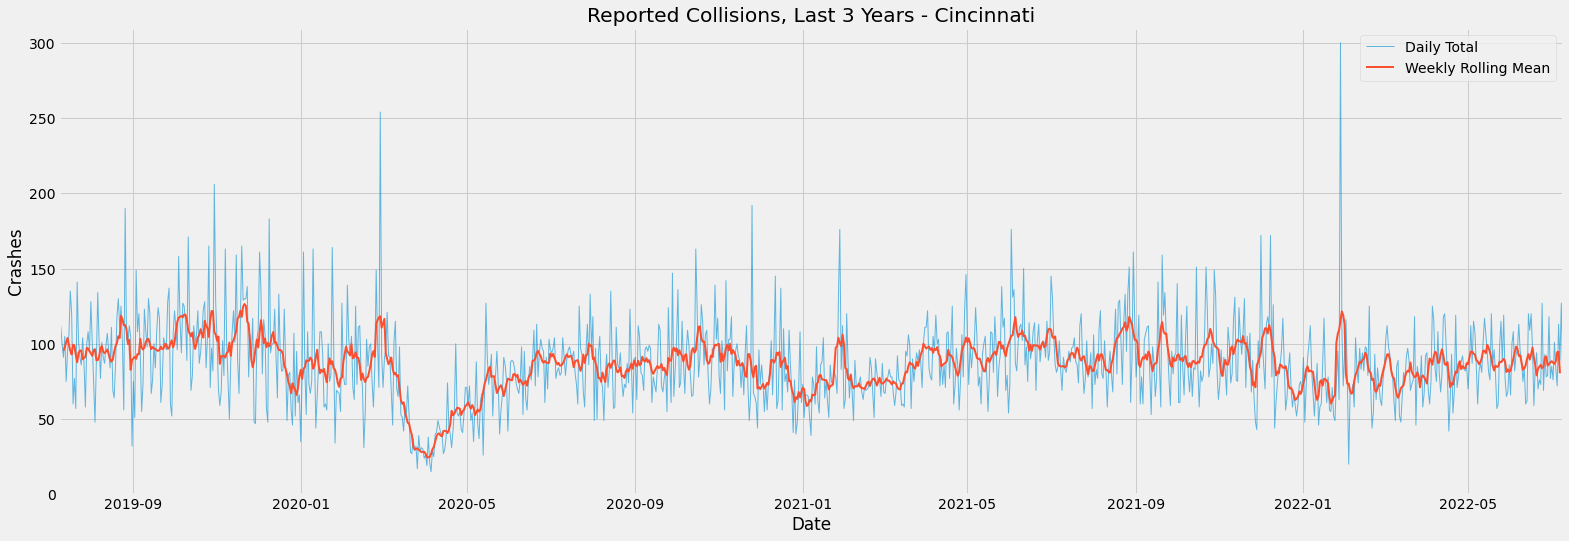

In [173]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(cinCrashes.index, cinCrashes.values, linewidth=1, alpha=0.6, label='Daily Total')
plt.plot(cinCrashes.index, cinDF["rolling"], linewidth=2, label='Weekly Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Reported Collisions, Last 3 Years - Cincinnati')
plt.legend()
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 310)
# plt(cinCrashes.index, cinDF["rolling"])

##### Now that's more like it. The orange-red line shows a rolling average of the 3 days on either side of each day (7 in total), thus negating any cyclical noise caused by differences in days of the week.

##### This smooths out the sharpest oscillations and gives a better view of the overall trend. The March 2020 drop is now obvious, as is the gradual ramp up afterward.

##### Now it's time for the Louisville data. I had to download it in 2-month chunks for the same 3-year period thanks to [Kentucky's... *vintage* website,](http://crashinformationky.org/AdvancedSearch) so we now need to concatenate 18 CSV files.

##### Fortunately, the `os` and `glob` modules are here to help.

In [174]:
louTest = os.path.join("./assets", "louCrash*.csv")
louList = glob.glob(louTest)
louRaw = pd.concat(map(pd.read_csv, louList), ignore_index=True)
louRaw.head()

,IncidentID,AgencyORI,AgencyName,IncidentStatusDesc,County,RdwyNumber,Street,RoadwayName,StreetSfx,StreetDir,...,MannerofCollision,RdwyCharacter,LightCondition,RampFromRdwyId,RampToRdwyId,AcceptedDate,IsSecondaryCollision,OwnerBadge,IncidentStatus,Unnamed: 38
0,29797749,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,NaN,CENTRAL,AVE,NaN,...,REAR END,STRAIGHT & LEVEL,DAWN,NaN,NaN,3/10/2022 8:08:38 AM,False,5379,Accepted,NaN
1,29797750,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,US0031W,10500 BLK,DIXIE,HWY,NaN,...,REAR END,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:08:45 AM,False,2311,Accepted,NaN
2,29797757,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,NaN,DUMESNIL,ST,NaN,...,ANGLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:09:17 AM,False,5412,Accepted,NaN
3,29797758,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,1729,HILL,ST,W,...,ANGLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:09:21 AM,False,5412,Accepted,NaN
4,29797759,0568000,LOUISVILLE METRO POLICE DEPT,Accepted,JEFFERSON,NaN,NaN,CHEROKEE,RD,NaN,...,REAR END,CURVE & LEVEL,DAYLIGHT,NaN,NaN,3/10/2022 8:09:25 AM,False,5006,Accepted,NaN


##### Perfect. Now that we have all of our Louisville data in one file, we can apply the same techniques as before - with some adjustments for different data.

In [175]:
louMain = louRaw.filter(["NumberInjured", "NumberKilled", "DirAnalysisCode", "CollisionDate"], axis=1)
louMain.head()

,NumberInjured,NumberKilled,DirAnalysisCode,CollisionDate
0,0,0,OTHER INTERSECTION COLLISIONS,3/9/2022 12:00:00 AM
1,0,0,REAR END IN TRAFFIC LANES BOTH VEHICLES MOVING,3/9/2022 12:00:00 AM
2,4,0,ANGLE COLLISION - OTHER,3/9/2022 12:00:00 AM
3,1,0,1 VEHICLE ENTERING/LEAVING ENTRANCE,3/9/2022 12:00:00 AM
4,0,0,OTHER INTERSECTION COLLISIONS,3/9/2022 12:00:00 AM


In [176]:
louMain["CollisionDate"] = pd.to_datetime(louMain["CollisionDate"]).dt.date
louCrashes = louMain.groupby(["CollisionDate"]).size()
louCrashes.head()

CollisionDate
2019-07-09    73
2019-07-10    80
2019-07-11    70
2019-07-12    92
2019-07-13    59
dtype: int64

(0.0, 175.0)

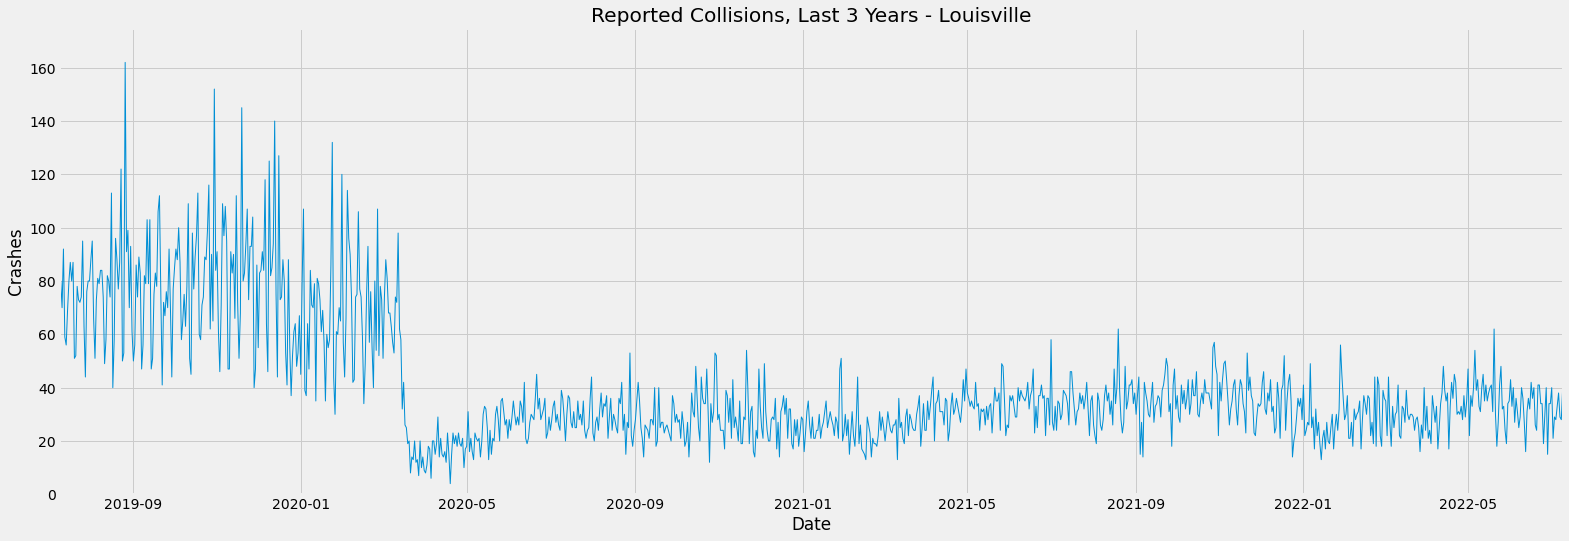

In [177]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(louCrashes.index, louCrashes.values, linewidth = 1)
plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Reported Collisions, Last 3 Years - Louisville')
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 175)

##### Here we have our raw line plot for Louisville. The March 2020 drop is plainly visible even before analysis, and it looks like the overall crash frequency afterward stays lower than Cincinnati's. Let's apply the rolling average technique and see what we get.

(0.0, 175.0)

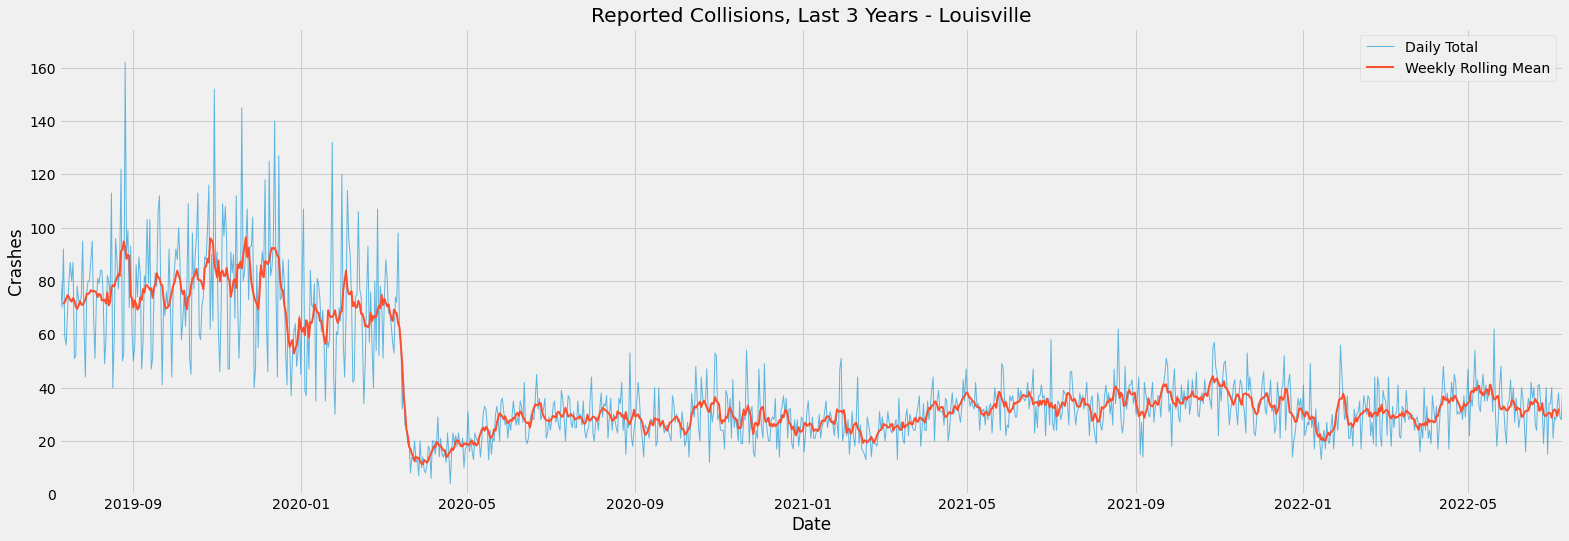

In [178]:
louDF = pd.DataFrame(louCrashes)
louDF['rolling'] = louDF.rolling(7, center=True).mean()
louDF.columns = ["total", "rolling"]

plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(louCrashes.index, louCrashes.values, linewidth=1, alpha=0.6, label='Daily Total')
plt.plot(louCrashes.index, louDF["rolling"], linewidth=2, label='Weekly Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Reported Collisions, Last 3 Years - Louisville')
plt.legend()
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 175)

##### We can now see the March 2020 drop very clearly indeed. The slow rise afterward still seems slower than Cincinnati's and never approaches its previous heights. Let's get a better look at the averages next to one another.

(0.0, 140.0)

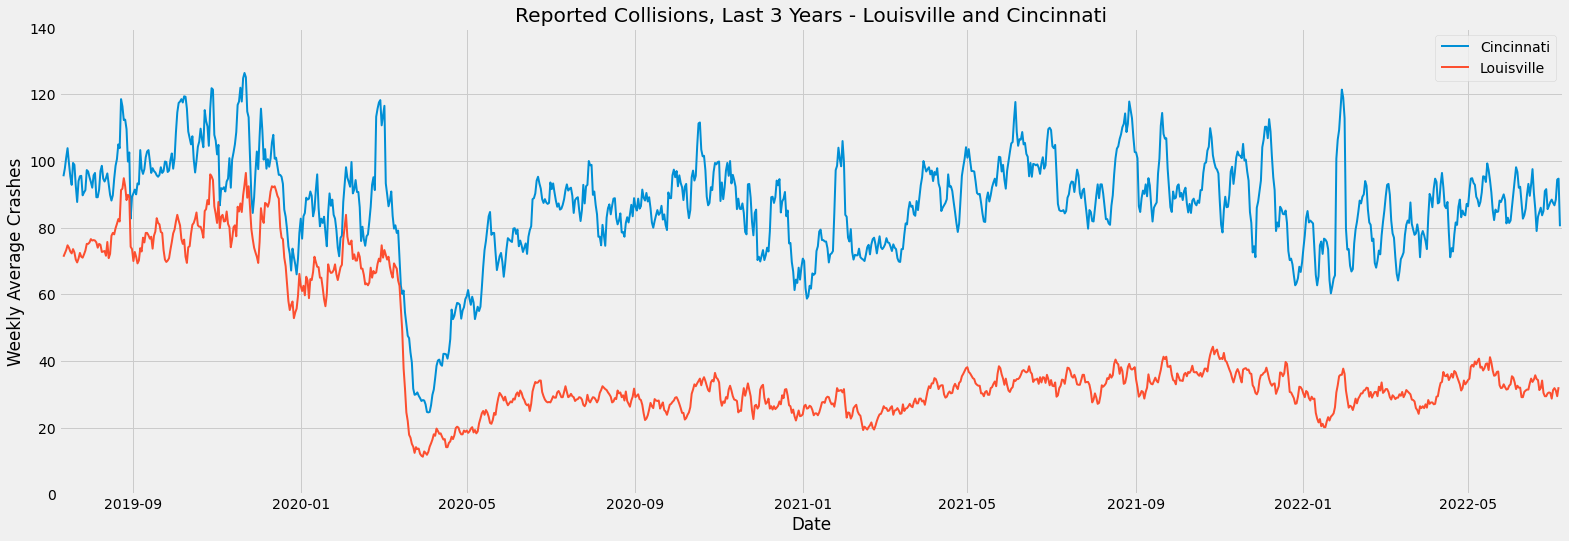

In [179]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 8))
plt.plot(cinCrashes.index, cinDF["rolling"], linewidth=2, label='Cincinnati')
plt.plot(louCrashes.index, louDF["rolling"], linewidth=2, label='Louisville')
plt.xlabel('Date')
plt.ylabel('Weekly Average Crashes')
plt.title('Reported Collisions, Last 3 Years - Louisville and Cincinnati')
plt.legend()
plt.xlim(pd.Timestamp('2019-07-09'), pd.Timestamp('2022-07-09'))
plt.ylim(0, 140)

##### Even without adjusting for population, the difference in trajectory between the two cities after early 2020 is apparent. But Cincinnati and Louisville are peer cities in the same region, so what gives? Well, it isn't totally clear, but I have a guess.

##### At the beginning of the COVID-19 pandemic, both [LMPD](https://www.wdrb.com/in-depth/lmpd-to-no-longer-respond-to-hit-and-run-wrecks-other-incidents/article_3fa29722-686a-11ea-9ae7-1fcf2d6fb288.html) and [Cincinnati PD](https://www.wcpo.com/news/coronavirus/starting-tuesday-cincinnati-pd-wont-respond-in-person-for-these-calls) released statements modifying their response protocols for certain types of 911 calls. Both their statements included verbage that offices were, in the words of Cincinnati's WCPO, "...only responding to auto collisions involving injuries or where vehicles are not drivable."

##### I wasn't able to find any official details regarding when Cincinnati PD resumed in-person responses, but their crash data suggests it happened only a few months later, in the summer of 2020. LMPD, on the other hand, responded to [a WAVE3 story](https://www.wave3.com/2022/04/21/police-arent-coming-troubleshooters-investigate-ramifications-lmpds-crash-response/) in April 2022 with a statement which read, in part, "In 2020, LMPD issued Special Order 20-004 adjusting patrol response to several non-emergency incidents. With motor vehicle collisions officers should be dispatched to injury collisions or when it is indicated there is trouble among the involved parties." The article concludes:

> Special Order 20-004 was issued at the start of the pandemic in 2020, limiting response to non-injury crashes and non-injury hit-and-runs in order to “risk *[sic]* exposure to the virus.” However, Kentucky Gov. Andy Beshear abolished COVID limitations a year ago, and the COVID map has been green for some time.<br><br>”It’s getting pretty long now,” Ward said. “The requirements for masks, city has opened back up — if they’re still using this as the temporary reason not to do this, it’s time to stop that.”<br><br>”What people fail to understand is that these insurance companies, they put exclusions in their policies, so that if there’s not a proper investigation, there’s not proper documentation, they can deny,” Marshbank said.<br><br>Meanwhile, the complaints are piling up. Marshbank said he just added another case of a severe damage crash, a 911 refusal to send an officer, and when the victim tried to flag down an LMPD officer driving by, she claims they accelerated past her and ignored her.

